# Stock on You: A Network Analysis of the Top 50 S&P Stocks

Exploring Relationships and Sector Dominance in the Stock Market Landscape

# Introduction

The financial markets are a fascinating and intricate ecosystem, where the fortunes of companies interweave and influence each other. At the heart of this vast system lies the S&P 500 index, a powerful barometer that measures the pulse of the U.S. stock market. This index represents a formidable force, boasting a staggering $7.1 trillion in assets and constituting nearly 80% of the market capitalization on U.S. stock exchanges [1].

**Introduction to S&P 500**

S&P, short for Standard and Poor, owes its name to the two founding financial companies. It was officially introduced on March 4, 1957, by Standard & Poor. Subsequently, McGraw-Hill acquired it in 1966. As of 2022, the ownership of S&P is in the hands of S&P Dow Jones Indices, a joint venture comprising S&P Global (previously known as McGraw Hill Financial), CME Group, and News Corp, the owner of Dow Jones [2].

Over the years, the S&P 500 has demonstrated its resilience and potential for growth, boasting an impressive average 10-year annual return of 13.9% as of January 7, 2022 [3]. This remarkable performance has made it a significant indicator for investors and a key player in the U.S. stock market.

**But what exactly does the S&P 500 mean for the average investor or the wider economy? What insights does it hold, and how does it impact the performance of individual companies and the overall market?**

**The Scale-Free Stock Network and Granger Causality Technique**

We'll explore the connections between top-performing companies in the S&P from 2013–2018. Through the lens of network science [4] and the power of Granger causality [5], we'll uncover hidden patterns and valuable connections that influence stock returns and market dynamics.

Imagine the financial markets as a vast web, with each company represented as a node and the relationships between them forming the threads that bind the system together. This network holds a fascinating secret - it follows a scale-free pattern, where a handful of influential companies play pivotal roles, while the majority have more limited impact.

Intriguingly, Granger causality, a statistical technique, enables us to explore the relationships between companies. By understanding how changes in one company's performance may predict the future behavior of another, we gain valuable insights into the flow of information and the influence of key players on market trends.

Armed with this knowledge, we'll delve into the realm of the most influential companies within the S&P network. As we decode the dynamics driving overall market performance, we'll reveal essential relationships that help make informed investment decisions and optimize portfolios.

Together, let's explore the captivating patterns and interconnections that shape their stock returns, revealing the fascinating landscape of finance.

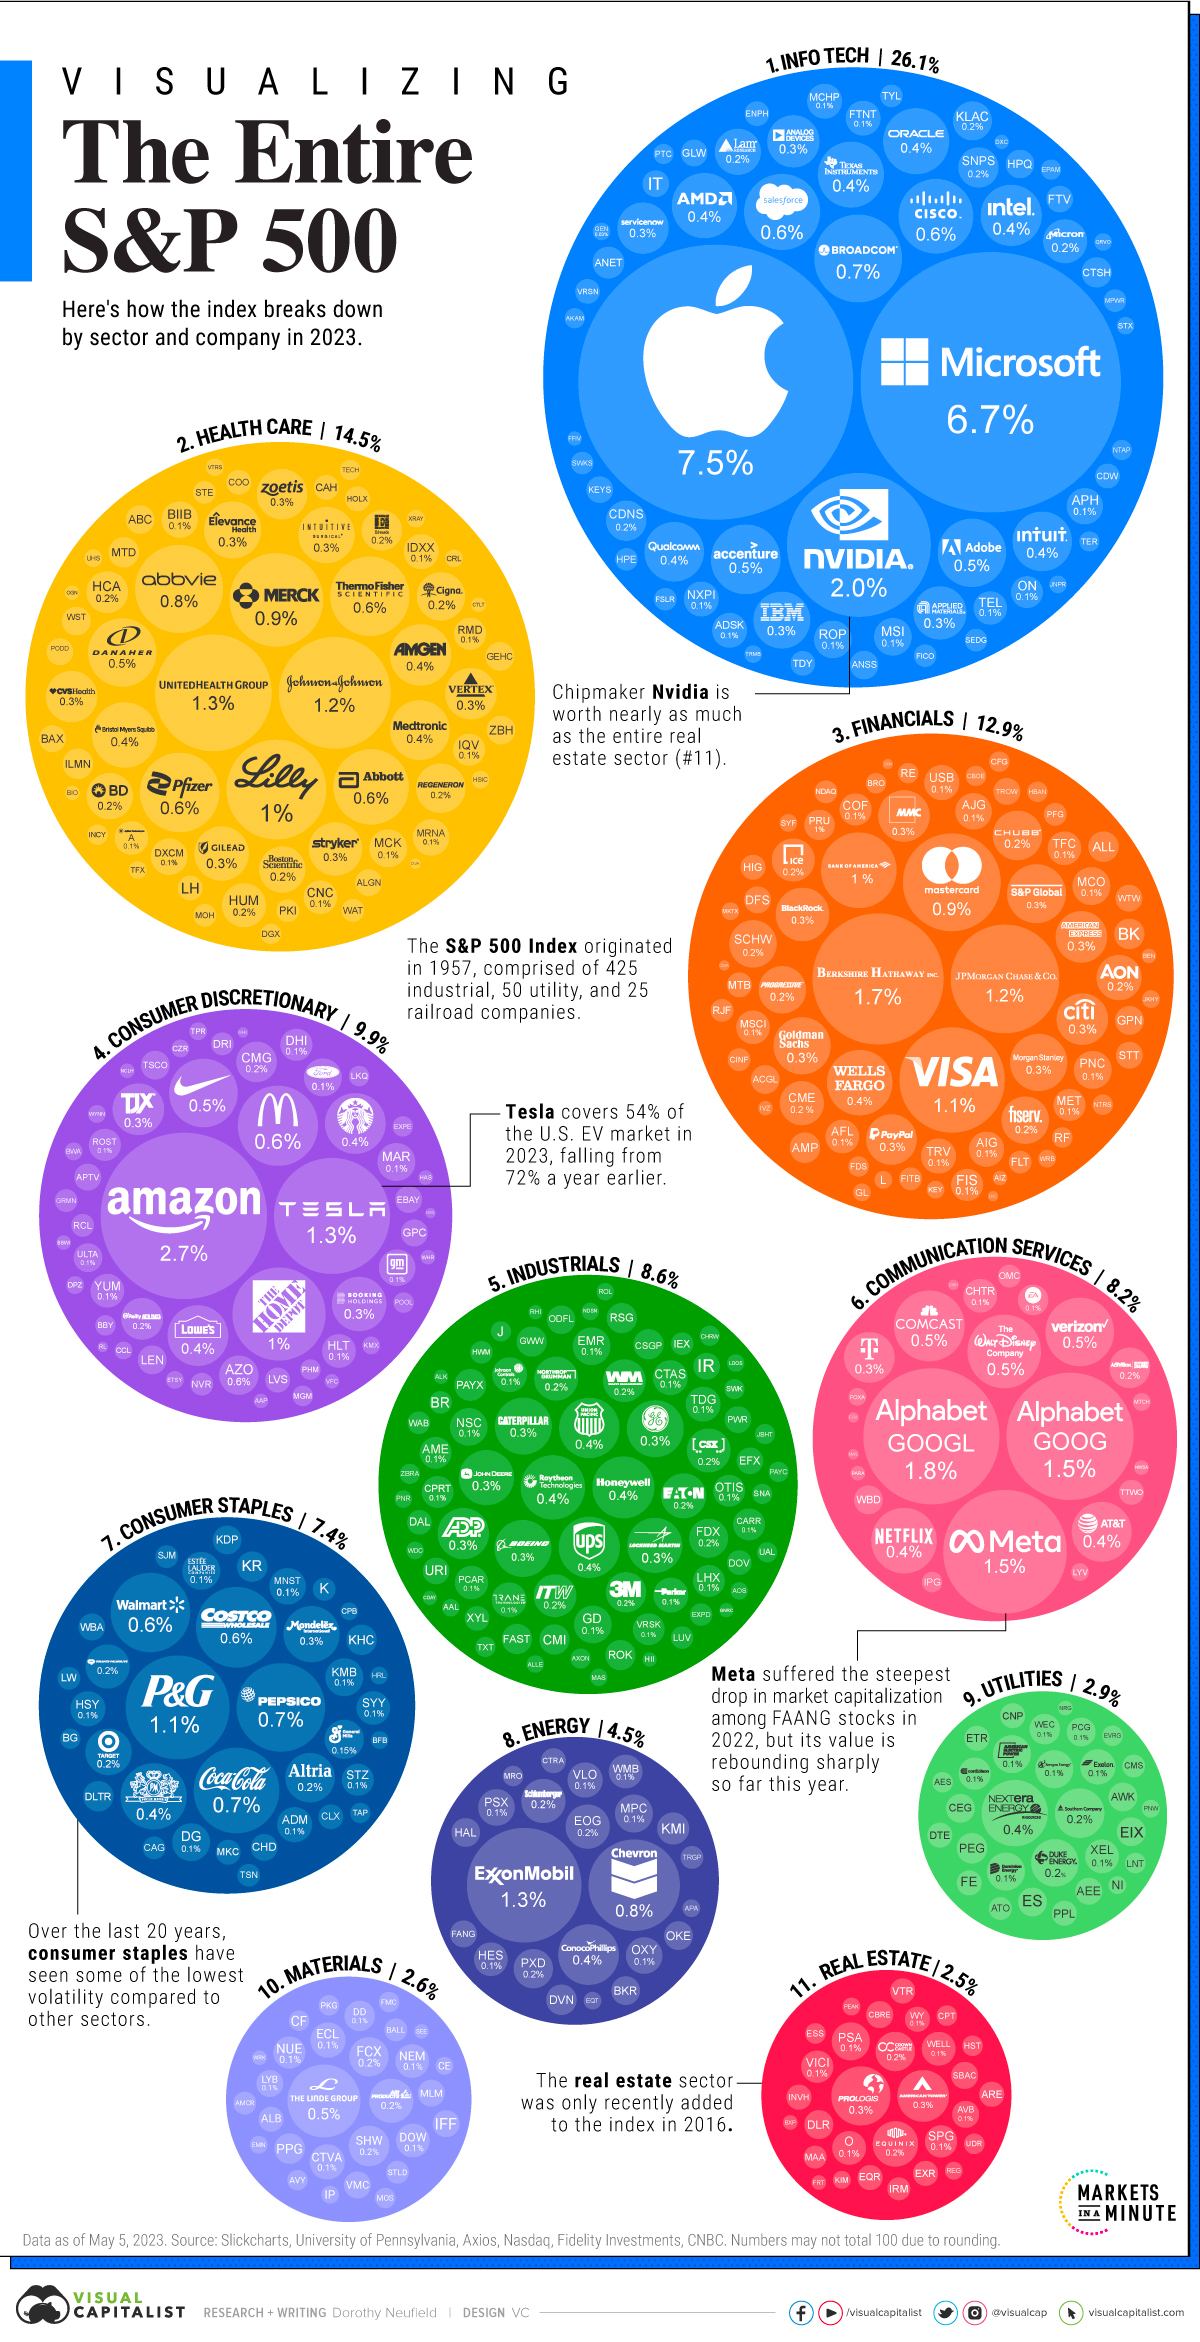

# Caveat

Granger causality is a tool to help us observe how one variable might influence another, but there could be other factors at play as well. So, while it's useful for observing relationships, we need to be careful about drawing firm conclusions about causation based solely on Granger causality.

# Data Source

The dataset containing historical stock prices for all companies currently listed on the S&P 500 index, spanning the 5-year period from 2013-2018 was sourced from [Cam Nugent's GitHub repository](https://github.com/CNuge/kaggle-code) [6]

Each file in the dataset includes the following columns:

Date: in the format yy-mm-dd
Open: stock price at market open (all in USD, as this is NYSE data)
High: highest price reached during the day
Low: lowest price reached during the day
Close: closing price
Volume: number of shares traded
Name: the stock's ticker name

For the purpose of exploratory data analysis and to enhance the dataset, sector classification for each S&P company based on [The Global Industry Classification Standard (GICS®)](https://www.msci.com/our-solutions/indexes/gics) [7] was obtained.

# Libraries and Packages

The comprehensive list of library and package imports sets the stage for conducting diverse data analysis, visualization, and network analysis tasks allowing for a broad range of data exploration and insight generation.

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from PIL import Image
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
import pandas as pd
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.cluster import SpectralClustering
from networkx.algorithms.components import strongly_connected_components
import community
import warnings
warnings.filterwarnings("ignore", category=Warning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Loading

## Stock Data

By running the following code, we can visualize the stock data.

In [2]:
# Load stock data from csv file
df = pd.read_csv('all_stocks_5yr.csv', parse_dates=['date'])
display(df)

date   open   high    low  close    volume name
0       08/02/2013  15.07  15.12  14.63  14.75   8407500  AAL
1       11/02/2013  14.89  15.01  14.26  14.46   8882000  AAL
2       12/02/2013  14.45  14.51  14.10  14.27   8126000  AAL
3       13/02/2013  14.30  14.94  14.25  14.66  10259500  AAL
4       14/02/2013  14.94  14.96  13.16  13.99  31879900  AAL
...            ...    ...    ...    ...    ...       ...  ...
619035  01/02/2018  76.84  78.27  76.69  77.82   2982259  ZTS
619036  02/02/2018  77.53  78.12  76.73  76.78   2595187  ZTS
619037  05/02/2018  76.64  76.92  73.18  73.83   2962031  ZTS
619038  06/02/2018  72.74  74.56  72.13  73.27   4924323  ZTS
619039  07/02/2018  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]

## Loading Sector Data and Merging with Stock Data

We load the GICS-based sector data and merge it with the stock data based on the common stock `name` column. We retain all records and add matching sector data.

In [3]:
# Load sector data from Excel file
stock_sectors_df = pd.read_excel("stock_sectors.xlsx")

# Merge the dataframes on the "name" column to add the "sector" column to df
merged_df = df.merge(stock_sectors_df[['name', 'sector']], on='name', how='left')
display(merged_df)

date   open   high    low  close    volume name       sector
0       08/02/2013  15.07  15.12  14.63  14.75   8407500  AAL  Industrials
1       11/02/2013  14.89  15.01  14.26  14.46   8882000  AAL  Industrials
2       12/02/2013  14.45  14.51  14.10  14.27   8126000  AAL  Industrials
3       13/02/2013  14.30  14.94  14.25  14.66  10259500  AAL  Industrials
4       14/02/2013  14.94  14.96  13.16  13.99  31879900  AAL  Industrials
...            ...    ...    ...    ...    ...       ...  ...          ...
619035  01/02/2018  76.84  78.27  76.69  77.82   2982259  ZTS  Health Care
619036  02/02/2018  77.53  78.12  76.73  76.78   2595187  ZTS  Health Care
619037  05/02/2018  76.64  76.92  73.18  73.83   2962031  ZTS  Health Care
619038  06/02/2018  72.74  74.56  72.13  73.27   4924323  ZTS  Health Care
619039  07/02/2018  72.70  75.00  72.69  73.86   4534912  ZTS  Health Care

[619040 rows x 8 columns]

# Background and Basics

To shed light on essential financial market trends and help inform decision-making for potential investment strategies, we conduct an Exploratory Data Analysis (EDA) and inspect the background and basics of the dataset. 

We inspect the count of stocks by sectors and visualize the Traded Volume by Sector per year for each sector and create an interactive bar plot to visualize the trends.

We also seek to understand Sector-Based Mean Close Prices and analyze Risk vs. Return for each stock to provide valuable insights for investors seeking optimal investment choices.

## Journey Through Sectors: Unraveling S&P Stocks' Trading Volumes Over Time

The consistent dominance of Information Technology (IT) and Financials sectors in terms of traded volume is observed. This indicates that these sectors attracted significant attention and interest from investors and traders during the 5-year period. A strong contender in the Top 3 Sectors is Consumer Discretionary.

* **IT**'s growth, innovation, and tech-driven businesses generated high investor interest. 

* **Financials**, being essential components of economies, were considered core investment options, leading to enduring demand.

* **Consumer Discretionary**'s consistent presence indicates its role in shaping market dynamics, driven by consumer spending and confidence in non-essential goods and services.

These sectors' resilience and significance reflect the interplay between economic trends, technology, and consumer behavior in the stock market landscape.

Understanding these dominant sectors is crucial for informed decisions and navigating financial market complexities.

In [4]:
# Convert 'date' column to datetime with the correct format
merged_df['date'] = pd.to_datetime(merged_df['date'], format='%d/%m/%Y')

# Calculate the total traded volume per year for each sector
merged_df['year'] = merged_df['date'].dt.year
sector_volume_per_year = merged_df.groupby(['year', 'sector'])['volume'].sum().reset_index()

# Create an interactive bar plot using Plotly with animation
fig = px.bar(sector_volume_per_year, x='volume', y='sector', color='sector',
             title='🚀 Unleashing the Dynamic Spirits: Sectors of S&P Stocks Based on Traded Volume 📈',
             labels={'volume': 'Traded Volume', 'sector': 'Sector'},
             animation_frame='year', orientation='h')

fig.update_layout(xaxis_title='Traded Volume', yaxis_title='Sector', showlegend=False)

# Save the plot as a GIF
pyo.plot(fig, filename='sector_volume_animation.gif', auto_open=False)

fig.show()

In [5]:
# Set a custom color palette for the plot
sns.set_palette('muted')

# EDA on count of stocks by sectors for each year
sector_volume_per_year = merged_df.groupby(['year', 'sector'])['volume'].sum().reset_index()

# Create an interactive animated plot using Plotly
fig = px.bar(sector_volume_per_year, x='volume', y='sector', animation_frame='year', color='sector', orientation='h',
             labels={'volume': 'Volume', 'sector': 'Sector'}, title='Stock Count by Sectors Over the Years')
fig.update_layout(showlegend=False)

# Save the plot as a GIF file using matplotlib.animation
years = sorted(merged_df['year'].unique())

def update(year):
    plt.cla()
    sns.barplot(data=sector_volume_per_year[sector_volume_per_year['year'] == year], y='sector', x='volume', palette='muted')
    plt.title(f"Unleashing the Dynamic Spirits: Sectors of S&P Stocks Based on Traded Volume - Year {year}", fontsize=16, fontweight='bold')
    plt.xlabel("Traded Volume")
    plt.ylabel("Sector")

fig, ax = plt.subplots(figsize=(18, 14))
ani = FuncAnimation(fig, update, frames=years)
ani.save('sector_volume_animation.gif', writer='pillow', fps=2)
plt.close()

## Inspecting Market Representation

In viewing the diversity of the stock market, we discover the highly, moderately, and scarcely represented sectors out of the 505 unique companies:

1. **Dominance of Financials, Industrials, Healthcare, Consumer Discretionary, and IT:**
Investors have a wide range of choices within these sectors, providing opportunities to diversify their portfolios and potentially achieve better risk-adjusted returns. The high count of unique stocks suggests that these sectors are dynamic and attractive for businesses and investors alike, contributing to their prominence in the market.

2. **Resilience of Consumer Staples:**
These sectors consist of companies that produce everyday necessities such as food, beverages, and household products. The stable nature of these businesses often makes them less susceptible to economic fluctuations, providing a defensive aspect to investors' portfolios. Despite having a moderate representation, the sector's consistent demand and essential nature make it an important component of a balanced investment strategy.

3. **Challenges in Utilities, Real Estate, Materials, Energy, and Communication Services:**
These five sectors have the lowest count of unique stocks. This is indicative of challenges related to market interest, business viability, or competitive dynamics. For example, the Utilities sector comprises companies providing essential services like electricity and water, but its capital-intensive nature and regulated operations might limit the number of companies in the market. Similarly, the Real Estate sector might have fewer unique stocks due to its asset-heavy nature and relatively slower growth compared to other sectors. The Materials, Energy, and Communication Services sectors might face industry-specific challenges or variations in demand, impacting the number of companies in these sectors.

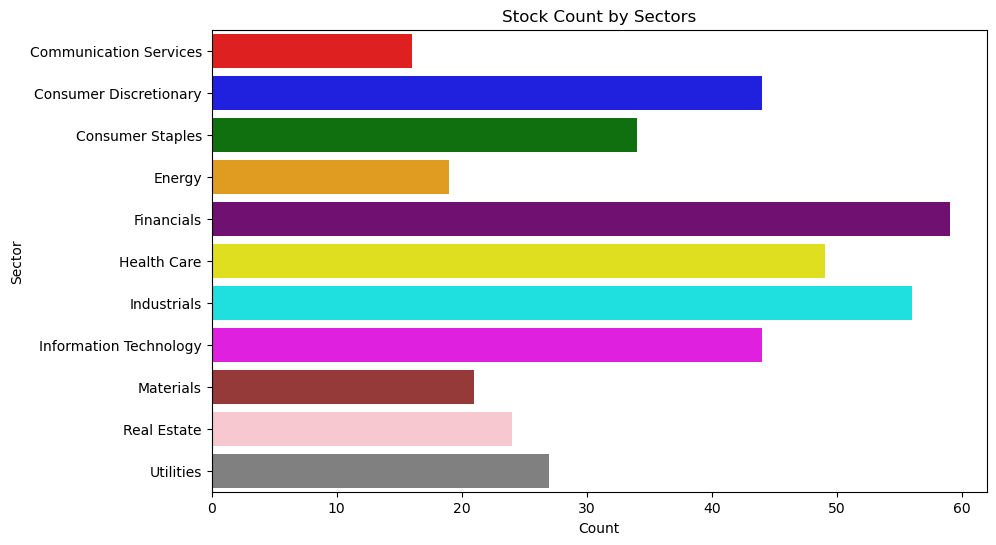

In [6]:
# EDA on count of stocks by sectors
stock_count_by_sector = merged_df.groupby('sector')['name'].nunique().reset_index()
stock_count_by_sector.rename(columns={'name': 'count'}, inplace=True)

# Define a custom list of distinct colors for each sector
custom_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'pink', 'gray']

# Plotting the Stock Count by Sectors using seaborn (Horizontal Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(data=stock_count_by_sector, x='count', y='sector', palette=custom_colors)
plt.title("Stock Count by Sectors")
plt.xlabel("Count")
plt.ylabel("Sector")
plt.show()

In [7]:
unique_stock_names = df['name'].unique()
num_unique_stocks = len(unique_stock_names)
print(f"There are {num_unique_stocks} unique stocks in the dataset.")

There are 505 unique stocks in the dataset.


In [8]:
all_stock_names = ' '.join(df['name'].unique())

In [9]:
upvote_mask = np.array(Image.open('upvote.png'))

In [10]:
wordcloud = WordCloud(width=800, height=400, background_color='white', mask=upvote_mask).generate(all_stock_names)

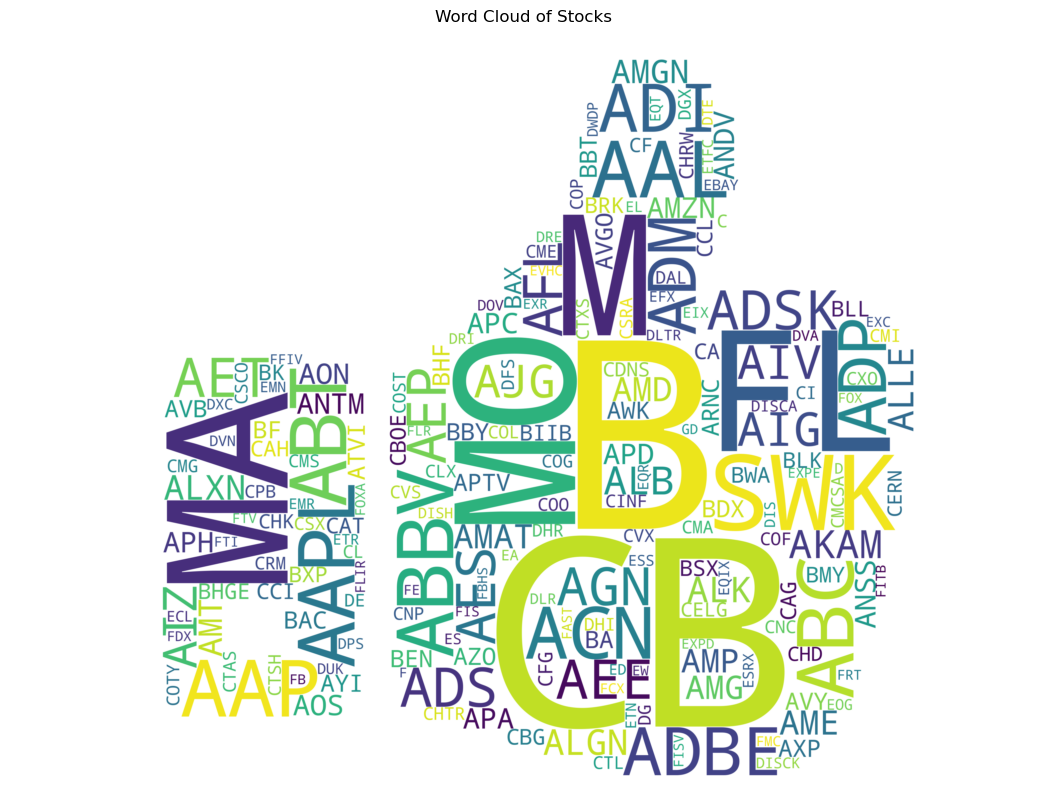

In [11]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Stocks')
plt.show()

## Unlocking Sector Insights: Mean Close Prices of Top S&P Stocks

To get a sense of the relative performance and market sentiment toward different sectors, we check out their mean close price. 

1. **Dominant Sectors:**
- **Communication Services and Consumer Discretionary** have the highest mean close prices, at approximately 131 and 109, respectively. These sectors show dominance in terms of higher average stock prices, suggesting strong performance and investor confidence in the companies within these sectors.

2. **Least Dominant Sectors:**
- **Utilities and Consumer Staples** have the lowest mean close prices, at around 53 and 70, respectively. These sectors exhibit relatively lower average stock prices compared to other sectors, indicating potentially less robust stock performance or lower market sentiment toward these industries.

3. **Financials, Industrials, Health Care, and Real Estate:**
- These sectors have mean close prices ranging from approximately 68 to 105. They occupy an intermediate position, reflecting moderate average stock prices and potential performance. Investors might find opportunities for growth and stability in these sectors.

4. **Information Technology, Materials, and Energy:**
- These sectors fall in the mid-range, with mean close prices between approximately 66 to 83. They represent sectors with average stock prices that are not the highest but not the lowest either, signifying moderate performance and investor interest.

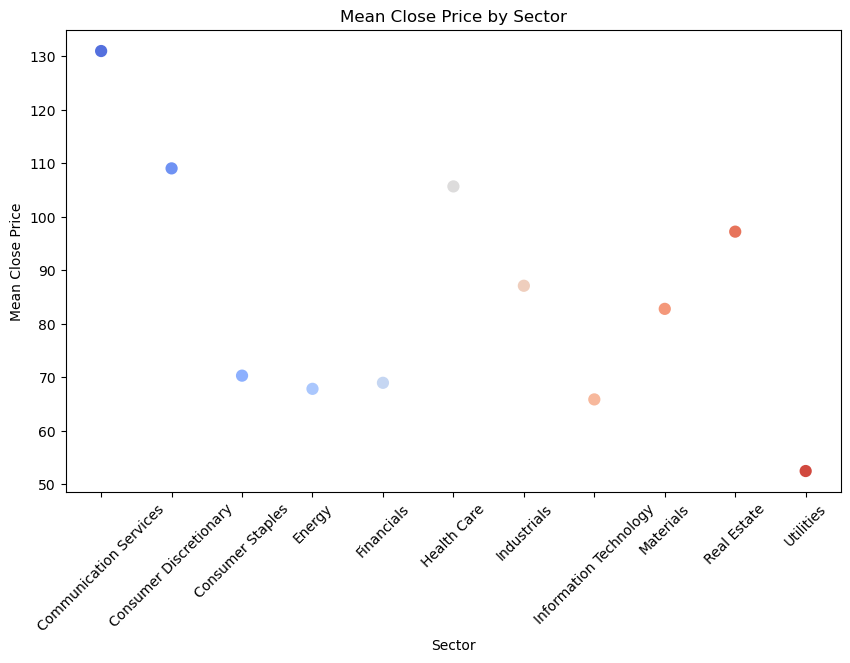

In [12]:
# EDA on highest mean close price by sector
mean_close_by_sector = merged_df.groupby('sector')['close'].mean()

# Plotting the Mean Close Price by Sector using seaborn point plot
plt.figure(figsize=(10, 6))
sns.pointplot(x=mean_close_by_sector.index, y=mean_close_by_sector.values, palette='coolwarm')
plt.title("Mean Close Price by Sector")
plt.xlabel("Sector")
plt.ylabel("Mean Close Price")
plt.xticks(rotation=45)
plt.show()

## Risk-Return Rock Stars

The volatility (standard deviation of returns) for each stock and the mean return for each stock can be used to analyze the risk and return profiles of the different stocks in the dataset. 

Exploration and visualization of the data reveals the sectors' respective spot in the Risk-Return Quadrant.

**1. High Return, Low Risk Sectors:**
- **Financials and Industrials:** These sectors are known for housing established and stable companies with steady revenue streams, making them less susceptible to market downturns. They offer attractive dividend yields and tend to perform well during economic expansions.
- **Consumer Discretionary and Consumer Staples:** These sectors cater to different consumer needs. Consumer Discretionary includes companies providing non-essential goods and services, while Consumer Staples comprises essential items. Their consistent performance reflects their resilience regardless of the economic environment.

**2. High Return, High Risk Sectors:**
- **Health Care and Information Technology:** These sectors offer high returns due to the presence of growth-oriented companies and biotech innovations. However, their stock prices can be highly sensitive to market sentiment and economic events, leading to higher volatility and risk.
- **Communication Services:** This sector faces fluctuations in changing consumer preferences and varying demand. While they can offer high returns during specific periods, their exposure to market volatility contributes to higher risk.

**3. Low Return, Low Risk Sectors:**
- **Utilities** are defensive, providing essential goods and services with steady demand. Investors seeking stability and regular dividends often favor them, leading to a higher number of stocks in these sectors.

**4. Low Return, High Risk Sectors:**
- **Energy:** This sector is influenced by commodity prices and geopolitical events, leading to lower returns despite higher risk.
- **Real Estate and Materials:** Their limited representation in this category suggests that some stocks in these sectors may have underperformed due to specific company-related factors or macroeconomic conditions, leading to lower returns combined with higher risk.

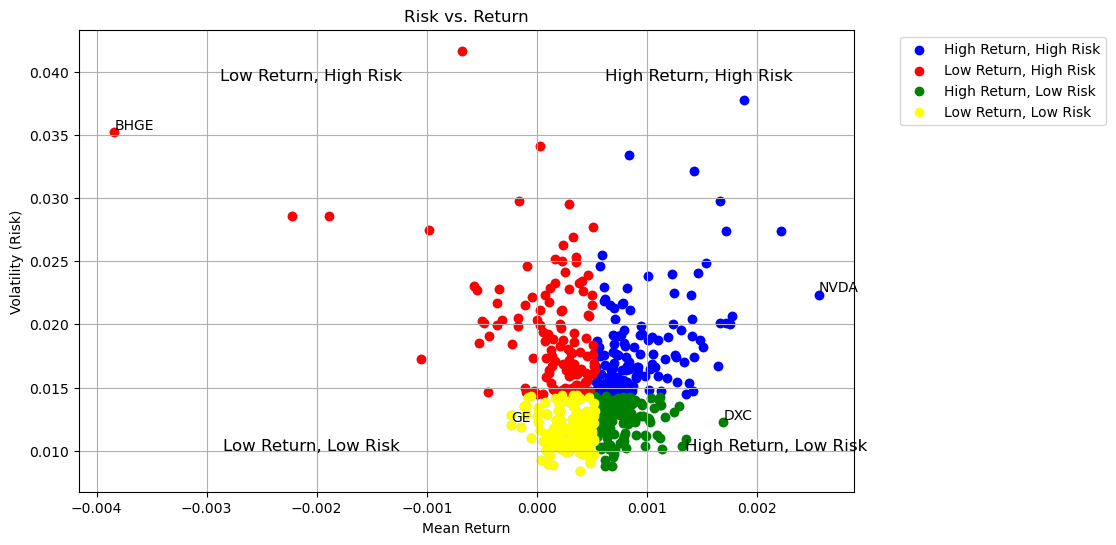

In [13]:
# Calculate daily returns for each stock
df['return'] = df.groupby('name')['close'].pct_change()

# Calculate volatility (standard deviation) for each stock
volatility_df = df.groupby('name')['return'].std().reset_index()
volatility_df.rename(columns={'return': 'volatility'}, inplace=True)

# Calculate mean return for each stock
mean_return_df = df.groupby('name')['return'].mean().reset_index()
mean_return_df.rename(columns={'return': 'mean_return'}, inplace=True)

# Merge the volatility and mean return DataFrames
risk_return_df = pd.merge(volatility_df, mean_return_df, on='name')

# Define the quadrants based on mean return and volatility thresholds
high_return_high_risk = risk_return_df[(risk_return_df['mean_return'] > risk_return_df['mean_return'].median()) &
                                      (risk_return_df['volatility'] > risk_return_df['volatility'].median())]
low_return_high_risk = risk_return_df[(risk_return_df['mean_return'] <= risk_return_df['mean_return'].median()) &
                                     (risk_return_df['volatility'] > risk_return_df['volatility'].median())]
high_return_low_risk = risk_return_df[(risk_return_df['mean_return'] > risk_return_df['mean_return'].median()) &
                                      (risk_return_df['volatility'] <= risk_return_df['volatility'].median())]
low_return_low_risk = risk_return_df[(risk_return_df['mean_return'] <= risk_return_df['mean_return'].median()) &
                                     (risk_return_df['volatility'] <= risk_return_df['volatility'].median())]

# Identify the stock with the highest return at the lowest risk
highest_return_lowest_risk_stock = high_return_low_risk[high_return_low_risk['mean_return'] == high_return_low_risk['mean_return'].max()]

# Identify the stock with the highest return and highest risk
highest_return_highest_risk_stock = high_return_high_risk[high_return_high_risk['mean_return'] == high_return_high_risk['mean_return'].max()]

# Identify the stock with the lowest return and lowest risk
lowest_return_lowest_risk_stock = low_return_low_risk[low_return_low_risk['mean_return'] == low_return_low_risk['mean_return'].min()]

# Identify the stock with the lowest return and highest risk
lowest_return_highest_risk_stock = low_return_high_risk[low_return_high_risk['mean_return'] == low_return_high_risk['mean_return'].min()]

# Plot the scatter plot to analyze the relationship between risk and return
plt.figure(figsize=(10, 6))
plt.scatter(risk_return_df['mean_return'], risk_return_df['volatility'], alpha=0.5)
plt.xlabel('Mean Return')
plt.ylabel('Volatility (Risk)')
plt.title('Risk vs. Return')
plt.grid(True)

# Add quadrant labels
plt.text(0.8, 0.9, "High Return, High Risk", ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.3, 0.9, "Low Return, High Risk", ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.9, 0.1, "High Return, Low Risk", ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
plt.text(0.3, 0.1, "Low Return, Low Risk", ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

# Plot each quadrant with different markers
plt.scatter(high_return_high_risk['mean_return'], high_return_high_risk['volatility'], color='blue', marker='o', label='High Return, High Risk')
plt.scatter(low_return_high_risk['mean_return'], low_return_high_risk['volatility'], color='red', marker='o', label='Low Return, High Risk')
plt.scatter(high_return_low_risk['mean_return'], high_return_low_risk['volatility'], color='green', marker='o', label='High Return, Low Risk')
plt.scatter(low_return_low_risk['mean_return'], low_return_low_risk['volatility'], color='yellow', marker='o', label='Low Return, Low Risk')

# Label stocks identified in each quadrant
highest_return_lowest_risk_stock_label = risk_return_df[risk_return_df['name'] == highest_return_lowest_risk_stock['name'].values[0]]
highest_return_highest_risk_stock_label = risk_return_df[risk_return_df['name'] == highest_return_highest_risk_stock['name'].values[0]]
lowest_return_lowest_risk_stock_label = risk_return_df[risk_return_df['name'] == lowest_return_lowest_risk_stock['name'].values[0]]
lowest_return_highest_risk_stock_label = risk_return_df[risk_return_df['name'] == lowest_return_highest_risk_stock['name'].values[0]]

plt.text(highest_return_lowest_risk_stock_label['mean_return'].values[0], highest_return_lowest_risk_stock_label['volatility'].values[0], highest_return_lowest_risk_stock_label['name'].values[0], ha='left', va='bottom', fontsize=10)
plt.text(highest_return_highest_risk_stock_label['mean_return'].values[0], highest_return_highest_risk_stock_label['volatility'].values[0], highest_return_highest_risk_stock_label['name'].values[0], ha='left', va='bottom', fontsize=10)
plt.text(lowest_return_lowest_risk_stock_label['mean_return'].values[0], lowest_return_lowest_risk_stock_label['volatility'].values[0], lowest_return_lowest_risk_stock_label['name'].values[0], ha='left', va='bottom', fontsize=10)
plt.text(lowest_return_highest_risk_stock_label['mean_return'].values[0], lowest_return_highest_risk_stock_label['volatility'].values[0], lowest_return_highest_risk_stock_label['name'].values[0], ha='left', va='bottom', fontsize=10)

# Move the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [14]:
high_return_low_risk_with_sectors = high_return_low_risk.merge(stock_sectors_df[['name', 'sector']], on='name', how='left')
high_return_low_risk_with_sectors['sector'].value_counts()

sector
Financials                24
Industrials               23
Information Technology    15
Health Care               11
Consumer Discretionary    10
Consumer Staples           6
Communication Services     5
Real Estate                4
Materials                  4
Utilities                  2
Name: count, dtype: int64

In [15]:
high_return_high_risk_with_sectors = high_return_high_risk.merge(stock_sectors_df[['name', 'sector']], on='name', how='left')
high_return_high_risk_with_sectors['sector'].value_counts()

sector
Health Care               21
Information Technology    20
Financials                20
Consumer Discretionary    18
Industrials               14
Consumer Staples           7
Materials                  6
Communication Services     4
Energy                     3
Utilities                  1
Name: count, dtype: int64

In [16]:
low_return_low_risk_with_sectors = low_return_low_risk.merge(stock_sectors_df[['name', 'sector']], on='name', how='left')
low_return_low_risk_with_sectors['sector'].value_counts()

sector
Utilities                 21
Consumer Staples          20
Real Estate               16
Health Care               14
Financials                12
Industrials               11
Consumer Discretionary     4
Energy                     3
Materials                  3
Information Technology     3
Communication Services     3
Name: count, dtype: int64

In [17]:
low_return_high_risk_with_sectors = low_return_high_risk.merge(stock_sectors_df[['name', 'sector']], on='name', how='left')
low_return_high_risk_with_sectors['sector'].value_counts()

sector
Energy                    13
Consumer Discretionary    12
Materials                  8
Industrials                8
Information Technology     6
Real Estate                4
Communication Services     4
Health Care                3
Utilities                  3
Financials                 3
Consumer Staples           1
Name: count, dtype: int64

# Building the Network

In building our Stock Network, we will focus and limit our analysis solely on the Top 50 S&P Stocks with the highest daily returns during the 5-year period.

In [18]:
# Calculate daily returns for each stock
merged_df['return'] = merged_df.groupby('name')['close'].pct_change()

In [19]:
top_50_stocks = merged_df.groupby('name')['return'].mean().nlargest(50).index
df_top_50 = merged_df[merged_df['name'].isin(top_50_stocks)]

# Select only the relevant columns for the network analysis
network_df = df_top_50[['name', 'sector', 'return', 'date']]
network_df

name       sector    return       date
0        AAL  Industrials       NaN 2013-02-08
1        AAL  Industrials -0.019661 2013-02-11
2        AAL  Industrials -0.013140 2013-02-12
3        AAL  Industrials  0.027330 2013-02-13
4        AAL  Industrials -0.045703 2013-02-14
...      ...          ...       ...        ...
582593  VRTX  Health Care  0.036675 2018-02-01
582594  VRTX  Health Care -0.039020 2018-02-02
582595  VRTX  Health Care -0.066771 2018-02-05
582596  VRTX  Health Care  0.026621 2018-02-06
582597  VRTX  Health Care -0.022603 2018-02-07

[58426 rows x 4 columns]

## Network EDA

### **Power Law and Diversity in the Network**

From the sector distribution of the Top 50 S&P Stocks, we can observe that:

**Power Law in Sector Imbalance:** A few sectors are highly dominant in terms of the number of top-performing stocks, while many other sectors have fewer representations among the top performers. This observation aligns with the power law distribution often seen in complex systems, including financial markets. 

- The Top 50 S&P Stocks are dominated by stocks from the **Health Care, Industrials, and IT** sectors. These three sectors together account for more than half of the Top 50 S&P Stocks. This indicates these sectors have performed well, resulting in their stocks being among the top performers in terms of returns.

- With 5 stocks represented, the **Consumer Discretionary** sector has more stocks in the Top 50 S&P Stocks compared to some other sectors. This suggests that the Consumer Discretionary sector is performing relatively well and has a higher presence among the top-performing stocks. Consumer Discretionary companies are involved in non-essential goods and services, such as retail, entertainment, and travel. The presence of more stocks from this sector in the Top 50 S&P Stocks may reflect strong consumer demand and spending patterns.

- Only 2 stocks are represented in the **Consumer Staples** sector, and 4 stocks each in the **Communication Services** and **Financials** sectors, suggests that some sectors may have a higher concentration of strong performers, while others have fewer.

- **Energy, Materials, Real Estate, and Utilities** sectors are not represented in the Top 50 S&P Stocks. This suggests lower returns or higher risk within those sectors during the analyzed period.

**Diverse Selection:** Although only 7 out of the original 11 sectors are represented in the Top 50 S&P Stocks, it still indicates diversity in the selection. Different industries and sectors have contributed to the overall high returns observed. While Health Care, Industrials, and Information Technology sectors dominate the top performers, the presence of stocks from Consumer Discretionary, Communication Services, and Financials sectors provides a more diverse range of investment opportunities.

Based on sector performance (returns-wise) and representation in the Top 50 S&P Stocks, investors and analysts can make informed decisions about portfolio diversification, risk management, and investment strategies. 

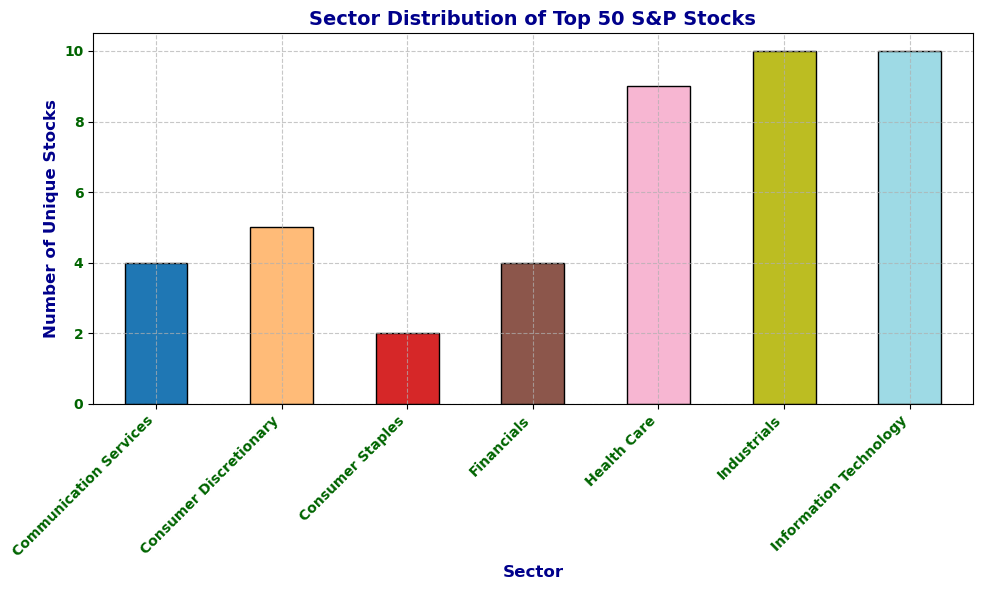

In [20]:
# Select only the relevant columns for the network analysis
network_df = df_top_50[['name', 'sector', 'return', 'date']]

# Calculate the count of unique stock names in each sector
sector_counts = network_df.groupby('sector')['name'].nunique()

# Define a color map for the bars
colors = plt.cm.tab20(np.linspace(0, 1, len(sector_counts)))

# Plot the sector distribution
plt.figure(figsize=(10, 6))
sector_counts.plot(kind='bar', color=colors, edgecolor='black')
plt.xlabel('Sector', color='darkblue', fontsize=12, fontweight='bold')
plt.ylabel('Number of Unique Stocks', color='darkblue', fontsize=12, fontweight='bold')
plt.title('Sector Distribution of Top 50 S&P Stocks', color='darkblue', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', color='darkgreen', fontsize=10, fontweight='bold')
plt.yticks(color='darkgreen', fontsize=10, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Top Performing Sectors based on Average Yearly Returns

In this analysis, we identify the top performing sectors and their corresponding average yearly returns.

1. **Consumer Staples** and **Communication Services** sectors exhibited strong performance across multiple years, demonstrating their reliability as sectors with top-performing stocks.
2. The **IT** sector consistently featured as one of the top performers, showcasing its significance in driving high returns.
3. The **Health Care** sector showed consistent performance, making it a reliable choice for investors seeking stable returns over the years.
4. The **Financials** sector demonstrated varying performance over the years, suggesting fluctuations in market conditions and economic factors impacting returns.
5. Consumer-oriented sectors (**Consumer Discretionary and Consumer Staples**) consistently appeared among the top performers, indicating a sustained demand for their products and services.

In [21]:
# Select only the relevant columns for the network analysis
network_df = df_top_50[['name', 'sector', 'return', 'date']]

# Calculate average yearly returns for each stock within each sector
network_df['year'] = network_df['date'].dt.year
sector_yearly_returns = network_df.groupby(['sector', 'year'])['return'].mean().reset_index()

# Define a custom color palette for the sectors
sector_colors = {'Communication Services': '#1f77b4',
                 'Consumer Discretionary': '#ff7f0e',
                 'Consumer Staples': '#2ca02c',
                 'Financials': '#d62728',
                 'Health Care': '#9467bd',
                 'Industrials': '#8c564b',
                 'Information Technology': '#e377c2'}

# Create an interactive horizontal bar chart for sector performance over time
fig = px.bar(sector_yearly_returns, x='return', y='sector', animation_frame='year',
             orientation='h', title='Sector Performance Over Time: Average Yearly Return',
             labels={'return': 'Average Yearly Return', 'sector': 'Sector', 'year': 'Year'},
             color='sector', color_discrete_map=sector_colors)

# Set plot layout
fig.update_layout(xaxis_tickangle=-45, yaxis_categoryorder='total ascending')

# Show the interactive plot
fig.show()

In [22]:
# Select only the relevant columns for the network analysis
network_df = df_top_50[['name', 'sector', 'return', 'date']]

# Calculate average yearly returns for each stock within each sector
network_df['year'] = network_df['date'].dt.year
sector_yearly_returns = network_df.groupby(['sector', 'year'])['return'].mean().reset_index()

# Define a custom color palette for the sectors
sector_colors = {'Communication Services': '#1f77b4',
                 'Consumer Discretionary': '#ff7f0e',
                 'Consumer Staples': '#2ca02c',
                 'Financials': '#d62728',
                 'Health Care': '#9467bd',
                 'Industrials': '#8c564b',
                 'Information Technology': '#e377c2'}

# Sort the sectors based on the average yearly return in the first year
first_year = sector_yearly_returns['year'].min()
sector_order = sector_yearly_returns[sector_yearly_returns['year'] == first_year].sort_values(by='return')['sector']

# Create the initial plot
fig, ax = plt.subplots(figsize=(18, 14))
bars = ax.barh(sector_order, np.zeros(len(sector_order)), color=[sector_colors[sector] for sector in sector_order])

# Function to update the plot for each animation frame
def update(frame):
    current_year_data = sector_yearly_returns[sector_yearly_returns['year'] == frame]
    current_values = current_year_data.set_index('sector').reindex(sector_order)['return']
    for bar, value in zip(bars, current_values):
        bar.set_width(value)
    ax.set_xlim(0, max(current_values) * 1.1)
    ax.set_title(f'Sector Performance of the Top 50 Stocks Over Time: Average Yearly Return ({frame})')
    ax.set_xlabel('Average Yearly Return')
    ax.set_ylabel('Sector')

# Animate the plot using FuncAnimation
ani = FuncAnimation(fig, update, frames=sector_yearly_returns['year'].unique(),
                    repeat=False, interval=1000, blit=False)

# Save the animation as a GIF
ani.save('sector_performance.gif', writer='pillow')

# Show the animation (if needed)
plt.close()

# Network Visualization

## About the Stock (Granger Causality) Network

The network of Top 50 S&P Stocks from 7 Sectors is constructed based on the Granger causality analysis, and the edges represent the relationships between stocks. 

The presence of an edge from stock A to stock B indicates that stock A is influencing stock B's returns, according to the Granger causality test.

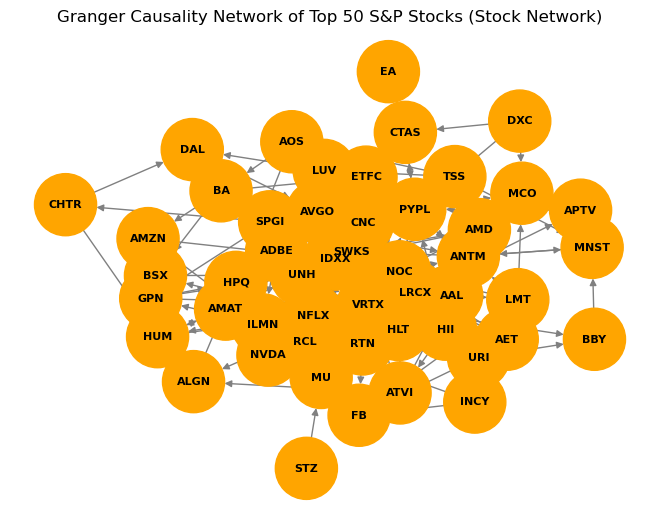

In [23]:
# Pivot the DataFrame to have each stock's return as a column
pivot_df = network_df.pivot(index='date', columns='name', values='return').dropna()

# Initialize an empty DataFrame to store the Granger causality results
granger_df = pd.DataFrame(index=pivot_df.columns, columns=pivot_df.columns)

# Calculate Granger causality for each pair of stocks
for stock1 in pivot_df.columns:
    for stock2 in pivot_df.columns:
        if stock1 != stock2:
            data = pivot_df[[stock1, stock2]].dropna()
            result = grangercausalitytests(data, maxlag=10, verbose=False)
            granger_df.loc[stock1, stock2] = result[10][0]['ssr_ftest'][1]

# Threshold the Granger causality values (e.g., p-value < 0.05) to create an adjacency matrix
threshold = 0.05
adjacency_matrix = (granger_df < threshold).astype(int)

# Create a directed graph
G = nx.DiGraph()

# Add nodes (stocks) to the graph
G.add_nodes_from(pivot_df.columns)

# Add edges (relationships) to the graph based on the adjacency matrix
for i, row in adjacency_matrix.iterrows():
    for j, value in row.items():
        if value == 1:
            G.add_edge(i, j)

# Find strongly connected components in the graph
strongly_connected_nodes = list(strongly_connected_components(G))

pos = nx.kamada_kawai_layout(G)  # Layout the nodes using a kamada kawai layout algorithm

# Highlight the strongly connected nodes with a different color
strongly_connected_color = 'orange'
node_colors = ['lightblue' if node not in set.union(*strongly_connected_nodes) else strongly_connected_color for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=8, font_weight='bold', edge_color='gray')
plt.title('Granger Causality Network of Top 50 S&P Stocks (Stock Network)')
plt.show()

## Key Metrics of the Stock Network

1. **Nodes**: 50
   - The total number of nodes (stocks) in the Stock Network. Each node represents a top-performing S&P stock.

2. **Edges**: 187
   - The total number of edges (relationships) in the network. An edge from stock A to stock B indicates that stock A is causing or influencing stock B's returns, as per the Granger causality test.

3. **Minimum Degree**: 1
   - The smallest number of direct relationships (according to the Granger causality test) that any stock has in the network. It represents the minimum number of links from a stock to other stocks.

4. **Maximum Degree**: 19
   - The largest number of direct relationships that any stock has in the network. It represents the maximum number of links from a stock to other stocks.

5. **Average Degree**: 7.48
   - The average number of direct relationships that each stock has in the network. It provides an indication of the interconnectedness and influence of stocks in the market.

6. **Average Shortest Path**: 0.322106
   - The average shortest path length between all pairs of nodes in the network. It represents the average distance or steps needed to travel from one stock to another through relationships. Smaller values indicate greater efficiency and influence among stocks in the network.

In [24]:
# Calculate the number of nodes (stocks) in the graph
N = G.number_of_nodes()

# Calculate the number of edges in the graph
L = G.number_of_edges()

# Calculate the minimum degree of nodes in the graph
k_min = min(G.degree(), key=lambda x: x[1])[1]

# Calculate the maximum degree of nodes in the graph
k_max = max(G.degree(), key=lambda x: x[1])[1]

# Calculate the average degree of nodes in the graph
k_avg = sum(dict(G.degree()).values()) / N

# Check if the graph is strongly connected
if nx.is_strongly_connected(G):
    # Calculate the average shortest path length in the graph
    avg_shortest_path = nx.average_shortest_path_length(G)
else:
    # Calculate the average shortest path length for each strongly connected component
    scc_avg_shortest_paths = []
    for subgraph in nx.strongly_connected_components(G):
        scc_avg_shortest_paths.append(nx.average_shortest_path_length(G.subgraph(subgraph)))
    avg_shortest_path = np.mean(scc_avg_shortest_paths)

# Create a dictionary with the network summary details
network_summary = {
    'Metric': ['Nodes', 'Edges', 'Minimum degree', 'Maximum degree', 'Average degree', 'Average Shortest Path'],
    'Value': [N, L, k_min, k_max, k_avg, avg_shortest_path]
}

# Create a DataFrame from the network summary dictionary
network_summary_df = pd.DataFrame(network_summary)

# Display the network summary DataFrame
display(network_summary_df)

Metric       Value
0                  Nodes   50.000000
1                  Edges  187.000000
2         Minimum degree    1.000000
3         Maximum degree   19.000000
4         Average degree    7.480000
5  Average Shortest Path    0.322106

## Key Network Metrics: Clustering Coefficient and Degree Values

Different combinations of clustering and degree values offer a glimpse into the network's structure and the role of individual stocks in shaping the interconnections of the Top 50 S&P Stocks.

From the clustering coefficient and degree information of the stocks, we can draw the following insights:

- **High Clustering, Low Degree:** Stocks like AET, APTV, EA, MNST, and STZ have relatively high clustering coefficients (close to 0.5) but low degrees (1 to 3). This indicates that while these stocks are part of tightly interconnected groups (high clustering), they have limited direct connections with other stocks (low degree).

- **High Clustering, High Degree:** Stocks like IDXX, INCY, RTN, SPGI, and VRTX have both high clustering coefficients (around 0.15 to 0.25) and high degrees (12 to 16). These stocks are part of well-connected clusters and have a substantial number of direct connections, suggesting they play a crucial role in the network's interactions.

- **Low Clustering, High Degree:** Stocks like AAL, ADBE, AMAT, ATVI, FB, and HPQ have relatively low clustering coefficients (around 0.05 to 0.16) but high degrees (around 6 to 15). These stocks have numerous direct connections, but their neighbors may not be as densely connected to each other.

- **Swing Centrality:** SWKS stands out with the highest degree (19) and a moderately high clustering coefficient (0.099). It indicates that SWKS has a strong presence in the network, being directly connected to many other stocks, and its neighbors also exhibit some level of clustering.

In [25]:
# Calculate the clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Create a DataFrame to store the clustering coefficient for each node
df_clustering = pd.DataFrame(clustering_coefficients.items(), columns=['Node', 'Clustering Coefficient'])

# Calculate the degree for each node in the graph
degrees = G.degree()

# Convert the dictionary of degrees to a DataFrame
df_degrees = pd.DataFrame(degrees, columns=['Node', 'Degree'])

# Merge the degree information into the existing DataFrame using the 'Node' column as the key
df_clustering = df_clustering.merge(df_degrees, on='Node')

# Print the DataFrame with clustering coefficients and degrees for each node
display(df_clustering)

# Calculate and print the average clustering coefficient
average_clustering_coefficient = df_clustering['Clustering Coefficient'].mean()
print(f"\nAverage Clustering Coefficient: {average_clustering_coefficient}")

Node  Clustering Coefficient  Degree
0    AAL                0.107143       8
1   ADBE                0.232143       8
2    AET                0.500000       2
3   ALGN                0.050000       5
4   AMAT                0.128571       9
5    AMD                0.000000       6
6   AMZN                0.166667       3
7   ANTM                0.074074      11
8    AOS                0.100000       5
9   APTV                0.000000       2
10  ATVI                0.050000       5
11  AVGO                0.081731      15
12    BA                0.066667       6
13   BBY                0.000000       3
14   BSX                0.000000       4
15  CHTR                0.000000       3
16   CNC                0.250000       5
17  CTAS                0.178571       6
18   DAL                0.000000       3
19   DXC                0.500000       3
20    EA                0.000000       1
21  ETFC                0.208333       9
22    FB                0.047619       7
23   GPN                0.250000       5
24   HII                0.090909      11
25   HLT                0.190476       7
26   HPQ                0.077778      10
27   HUM                0.035714       6
28  IDXX                0.083333      14
29  ILMN                0.143939      12
30  INCY                0.000000       3
31   LMT                0.000000       6
32  LRCX                0.098039      15
33   LUV                0.050000       5
34   MCO                0.083333       4
35  MNST                0.000000       4
36    MU                0.160714       8
37  NFLX                0.090909      12
38   NOC                0.109524      15
39  NVDA                0.166667       4
40  PYPL                0.084034      16
41   RCL                0.200000       6
42   RTN                0.161538      12
43  SPGI                0.128788      12
44   STZ                0.000000       1
45  SWKS                0.099415      19
46   TSS                0.071429       7
47   UNH                0.150000      14
48   URI                0.100000       5
49  VRTX                0.113636      12


Average Clustering Coefficient: 0.10963391393035354


## Scale-Free Stock Network: Discovering Power Law in the Interconnections Among Top 50 S&P Stocks

In this Stock Network, the degrees of nodes represent the number of direct relationships each stock has with others. A higher degree indicates more links to other stocks. The edges in the network indicate relationships, showing which stocks influence others' returns. The degree distribution follows a power law, indicating a few hub stocks with significant influence. This analysis provides insights into interconnections and dependencies among the Top 50 S&P Stocks, helping investors understand information flow and manage risk in their portfolios.

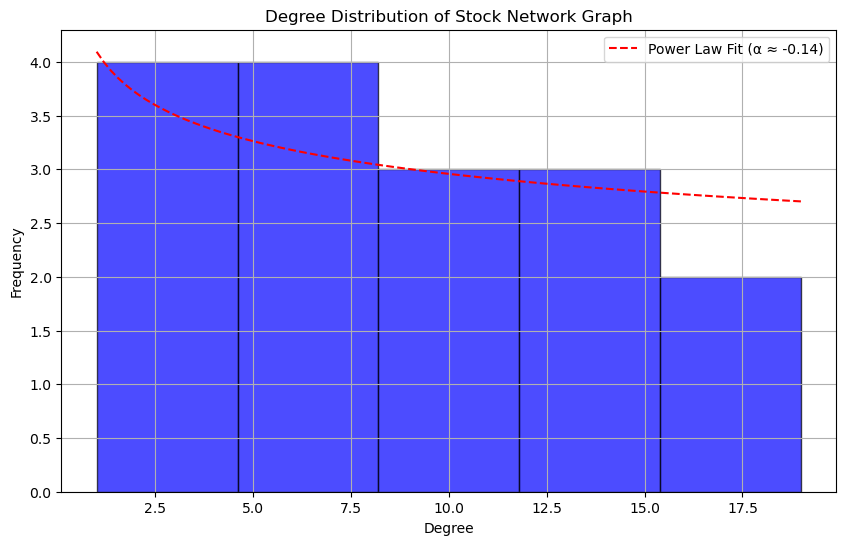

In [26]:
# Calculate the degrees of each stock in the graph
degree_data = G.degree()
df_stock_degree = pd.DataFrame(degree_data, columns=['Stock', 'Degree'])

# Plot the degree distribution
plt.figure(figsize=(10, 6))
degree_freq = df_stock_degree['Degree'].value_counts().sort_index()
degrees = degree_freq.index
frequency = degree_freq.values
plt.hist(degrees, bins=5, alpha=0.7, color='b', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of Stock Network Graph')
plt.grid(True)

# Fit a power law to the data
def power_law(x, alpha, A):
    return A * x**alpha

popt, _ = curve_fit(power_law, degrees, frequency)
alpha_fit, A_fit = popt

# Generate the power law line
x_fit = np.linspace(min(degrees), max(degrees), 100)
y_fit = power_law(x_fit, alpha_fit, A_fit)

# Plot the power law line
plt.plot(x_fit, y_fit, 'r--', label=f'Power Law Fit (α ≈ {alpha_fit:.2f})')

plt.legend()
plt.show()

In [27]:
# Calculate the in-degree centrality for each node
in_degree_centrality = nx.in_degree_centrality(G)

# Calculate the out-degree centrality for each node
out_degree_centrality = nx.out_degree_centrality(G)

# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Create a DataFrame with the number of nodes and their degrees
data = {
    'Stock Nodes': list(G.nodes()),
    'Degree': [G.degree(node) for node in G.nodes()],
    'In-Degree': [G.in_degree(node) for node in G.nodes()],
    'Out-Degree': [G.out_degree(node) for node in G.nodes()],
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'In-Degree Centrality': [in_degree_centrality[node] for node in G.nodes()],
    'Out-Degree Centrality': [out_degree_centrality[node] for node in G.nodes()]
}
df_stock_degree = pd.DataFrame(data)
df_stock_degree = df_stock_degree.sort_values('In-Degree', ascending=False)

# Display the DataFrame with the degree, in-degree, out-degree, in-degree centrality, and out-degree centrality of each node in the stock network graph
display(df_stock_degree)

Stock Nodes  Degree  In-Degree  Out-Degree  Degree Centrality  \
45        SWKS      19         13           6           0.387755   
40        PYPL      16         12           4           0.326531   
47         UNH      14         10           4           0.285714   
37        NFLX      12         10           2           0.244898   
32        LRCX      15          9           6           0.306122   
49        VRTX      12          8           4           0.244898   
26         HPQ      10          8           2           0.204082   
38         NOC      15          7           8           0.306122   
7         ANTM      11          7           4           0.224490   
36          MU       8          6           2           0.163265   
29        ILMN      12          6           6           0.244898   
22          FB       7          5           2           0.142857   
28        IDXX      14          5           9           0.285714   
0          AAL       8          5           3           0.163265   
11        AVGO      15          5          10           0.306122   
34         MCO       4          4           0           0.081633   
17        CTAS       6          4           2           0.122449   
27         HUM       6          4           2           0.122449   
1         ADBE       8          4           4           0.163265   
24         HII      11          4           7           0.224490   
4         AMAT       9          4           5           0.183673   
33         LUV       5          3           2           0.102041   
35        MNST       4          3           1           0.081633   
25         HLT       7          3           4           0.142857   
41         RCL       6          3           3           0.122449   
42         RTN      12          3           9           0.244898   
3         ALGN       5          3           2           0.102041   
46         TSS       7          3           4           0.142857   
6         AMZN       3          2           1           0.061224   
43        SPGI      12          2          10           0.244898   
8          AOS       5          2           3           0.102041   
5          AMD       6          2           4           0.122449   
14         BSX       4          2           2           0.081633   
21        ETFC       9          2           7           0.183673   
13         BBY       3          2           1           0.061224   
18         DAL       3          2           1           0.061224   
12          BA       6          2           4           0.122449   
23         GPN       5          2           3           0.102041   
20          EA       1          1           0           0.020408   
31         LMT       6          1           5           0.122449   
15        CHTR       3          1           2           0.061224   
10        ATVI       5          1           4           0.102041   
30        INCY       3          1           2           0.061224   
9         APTV       2          1           1           0.040816   
39        NVDA       4          0           4           0.081633   
19         DXC       3          0           3           0.061224   
44         STZ       1          0           1           0.020408   
16         CNC       5          0           5           0.102041   
2          AET       2          0           2           0.040816   
48         URI       5          0           5           0.102041   

    In-Degree Centrality  Out-Degree Centrality  
45              0.265306               0.122449  
40              0.244898               0.081633  
47              0.204082               0.081633  
37              0.204082               0.040816  
32              0.183673               0.122449  
49              0.163265               0.081633  
26              0.163265               0.040816  
38              0.142857               0.163265  
7               0.142857               0.081633  
36              0.122449          

# Network Centrality

Centrality measures play a crucial role in comprehending interconnected data structures, commonly referred to as graphs or networks.[8]

Leveraging graph theory, these measures assess the significance of individual nodes within a network, effectively filtering out irrelevant information and emphasizing nodes or clusters that warrant closer examination.

## Degree Centrality: Highest number of direct relationships with other stocks among the Top 50 S&P Stocks

The fact that Skyworks Solutions Inc. (SWKS) is identified as the central node based on degree centrality in the Stock Network indicates that this stock has the highest number of direct relationships with other stocks among the Top 50 S&P Stocks. In other words, SWKS is linked to a significant number of other stocks in the network, making it a critical player in influencing and being influenced by the returns of other stocks.

As the central node, SWKS may have a prominent role in transmitting information and trends across the network. Its strong connections to other stocks suggest that changes in SWKS's performance could potentially have ripple effects on other stocks and vice versa. Investors and analysts should pay close attention to SWKS's behavior, as it may serve as an indicator of broader market trends or sentiment.

The central position of SWKS in the network could also imply that the company operates in an industry or sector that plays a vital role in the overall market dynamics. Understanding the reasons behind SWKS's high degree centrality can provide valuable insights into the underlying factors driving its performance and its connections with other stocks.

However, it's important to note that centrality is just one aspect of a stock's position in the market, and further analysis is needed to fully understand its performance, financials, and potential for growth or risk. Nonetheless, SWKS's central role in the Stock Network highlights its significance and influence in the ever-changing landscape of the stock market.

SWKS is the central node in terms of degree centrality.
Sector of SWKS: Information Technology


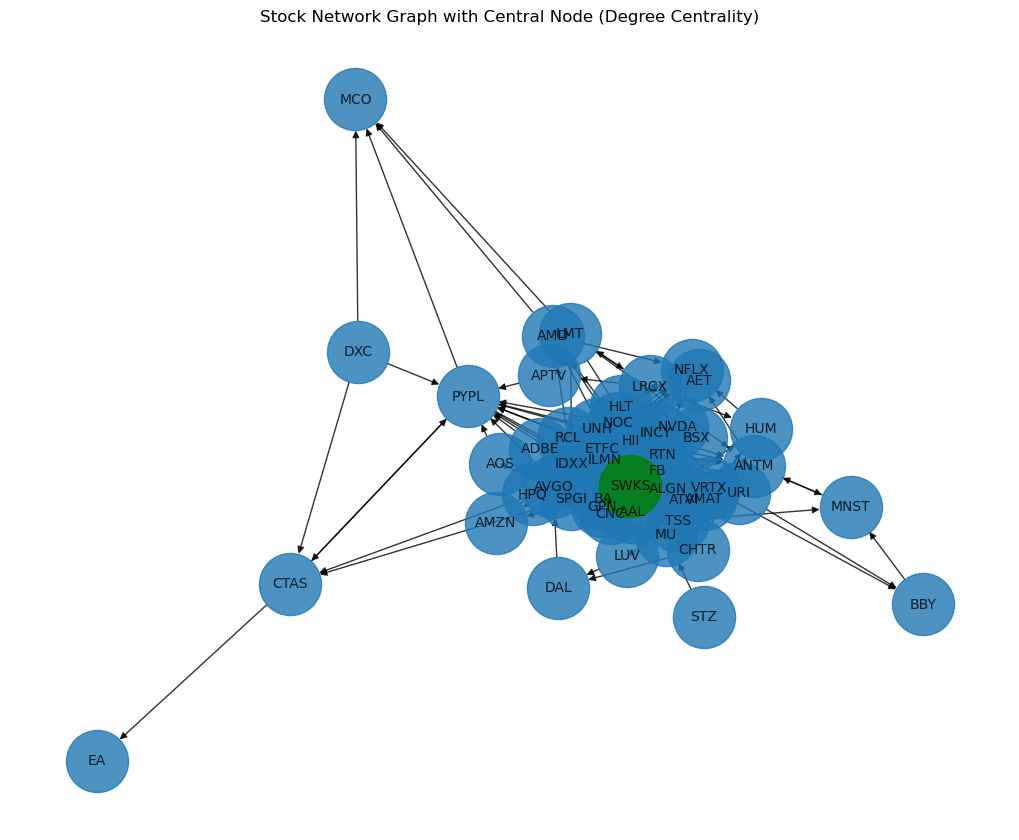

In [28]:
# Calculate the degree centrality for each node
degree_centrality = nx.degree_centrality(G)

# Find the node with the highest degree centrality (most central node)
central_node = max(degree_centrality, key=degree_centrality.get)

# Get the sector of the central node from the 'merged_df' DataFrame
central_node_sector = merged_df[merged_df['name'] == central_node]['sector'].iloc[0]

# Visualize the graph with the central node highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, alpha=0.8)

# Highlight the central node
nx.draw_networkx_nodes(G, pos, nodelist=[central_node], node_color='green', node_size=2000, alpha=0.8)

# Print the name of the central node and its sector
print(f"{central_node} is the central node in terms of degree centrality.")
print(f"Sector of {central_node}: {central_node_sector}")

# Set plot title
plt.title("Stock Network Graph with Central Node (Degree Centrality)")

# Show the plot
plt.show()

## Betweenness Centrality: Key Intermediary Between Stocks

The identification of SWKS as the central node based on betweenness centrality indicates that SWKS plays a critical role in connecting various other nodes (stocks) within the stock market network. In other words, SWKS acts as a key intermediary or broker, facilitating the flow of information and influence between different stocks in the network.

This centrality measure suggests that the performance and behavior of SWKS can significantly impact other stocks and vice versa. As a result, monitoring the performance and trends of SWKS can provide valuable insights into the overall dynamics of the stock market and potential interdependencies among various stocks.

Investors and market analysts should pay close attention to SWKS and its activities, as it may serve as an essential signal of market trends and potential contagion effects on other stocks. Furthermore, the prominence of SWKS in the betweenness centrality ranking underscores its significance in influencing market sentiment and investment decisions, making it a critical player in the stock market ecosystem.

SWKS is the central node in terms of betweenness centrality.
Sector of SWKS: Information Technology


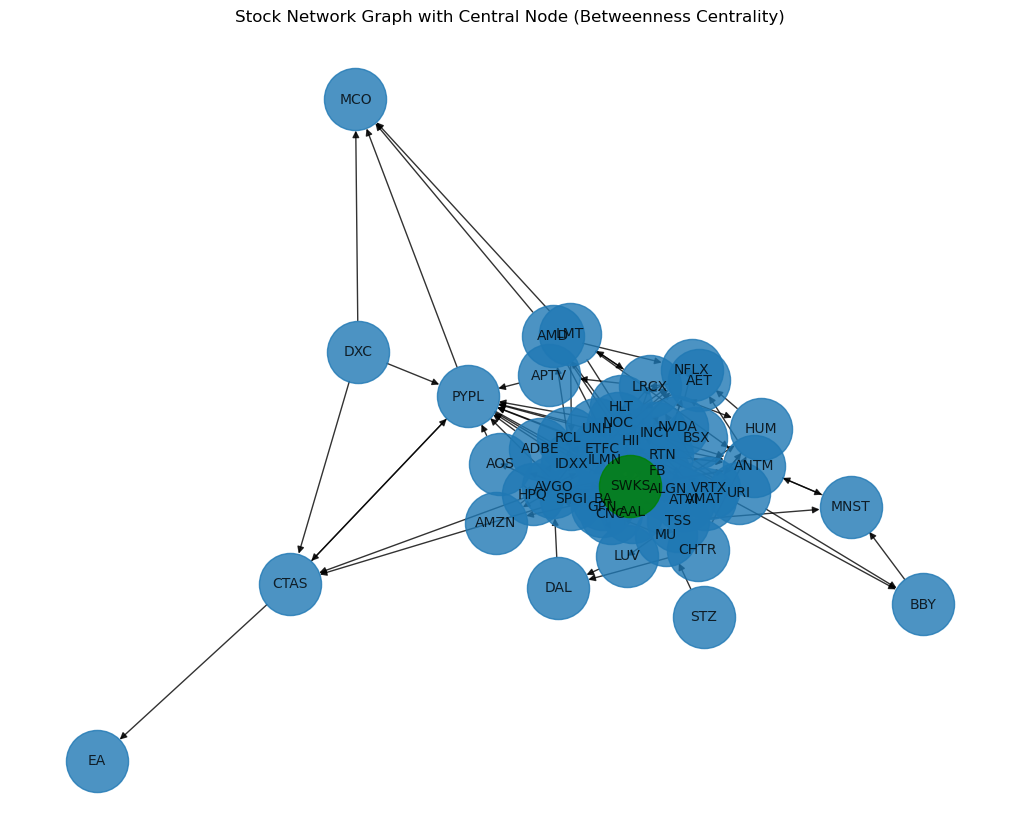

In [29]:
# Calculate the betweenness centrality for each node
betweenness_centrality = nx.betweenness_centrality(G)

# Find the node with the highest betweenness centrality (most central node)
central_node = max(betweenness_centrality, key=betweenness_centrality.get)

# Get the sector of the central node from the 'merged_df' DataFrame
central_node_sector = merged_df[merged_df['name'] == central_node]['sector'].iloc[0]

# Visualize the graph with the central node highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, alpha=0.8)

# Highlight the central node
nx.draw_networkx_nodes(G, pos, nodelist=[central_node], node_color='green', node_size=2000, alpha=0.8)

# Print the name of the central node and its sector
print(f"{central_node} is the central node in terms of betweenness centrality.")
print(f"Sector of {central_node}: {central_node_sector}")

# Set plot title
plt.title("Stock Network Graph with Central Node (Betweenness Centrality)")

# Show the plot
plt.show()

## Eigen Centrality: Strong Connection to Important Stocks

The high eigen centrality of Lam Research Corporation (LRCX) signifies its critical position in the stock market network and its potential to influence and be influenced by other key players, particularly within the technology sector. It indicates that LRCX has strong connections to other significant stocks in the network, particularly within the IT sector.

As a result, changes in LRCX's stock performance are likely to have a significant impact on other stocks within the IT sector and possibly even beyond. Investors and market participants often pay close attention to nodes with high eigen centrality, as they can serve as key indicators of market trends and potential investment opportunities.

Furthermore, LRCX's high eigen centrality within the IT sector indicates that it plays a vital role in shaping the dynamics and performance of the technology industry in the stock market. Its stock returns and performance may serve as a barometer for the overall health and direction of the IT sector. Therefore, LRCX's performance and movements are closely watched by investors and analysts, as they can provide valuable insights into broader trends within the technology sector and the stock market as a whole.

LRCX is the central node in terms of eigen centrality.
Sector of LRCX: Information Technology


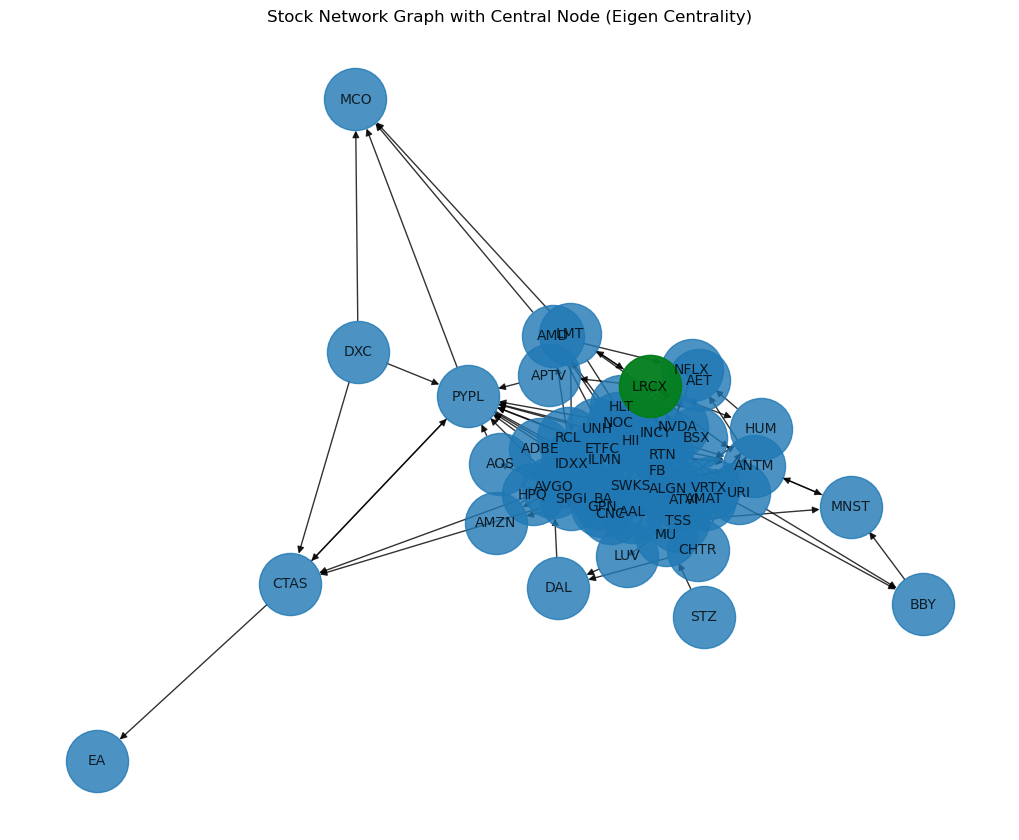

In [30]:
# Calculate the eigen centrality for each node
eigen_centrality = nx.eigenvector_centrality(G)

# Find the node with the highest eigen centrality (most central node)
central_node = max(eigen_centrality, key=eigen_centrality.get)

# Get the sector of the central node from the 'merged_df' DataFrame
central_node_sector = merged_df[merged_df['name'] == central_node]['sector'].iloc[0]

# Visualize the graph with the central node highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, alpha=0.8)

# Highlight the central node
nx.draw_networkx_nodes(G, pos, nodelist=[central_node], node_color='green', node_size=2000, alpha=0.8)

# Print the name of the central node and its sector
print(f"{central_node} is the central node in terms of eigen centrality.")
print(f"Sector of {central_node}: {central_node_sector}")

# Set plot title
plt.title("Stock Network Graph with Central Node (Eigen Centrality)")

# Show the plot
plt.show()

## Closeness Centrality: Key Source of Information Spread Between Stocks

The closeness centrality of SWKS implies that it is a highly central node in the stock network. Closeness centrality measures how quickly information can spread from a given node to all other nodes in the network. In the context of the stock network, a high closeness centrality for SWKS indicates that it is closely connected to many other stocks in the network and that information regarding SWKS's stock returns can quickly propagate to other stocks and vice versa.

This centrality measure suggests that SWKS has strong relationships and interactions with other stocks in the network, making it an influential player in the network dynamics. As a result, changes in SWKS's stock performance can have a significant impact on other stocks, and it may act as a critical conduit for information flow in the financial market.

Investors and analysts should take note of the high closeness centrality of SWKS, as it may signal that the company's performance and stock returns are closely linked to the overall dynamics of the stock market and can potentially serve as an indicator for broader market trends.

SWKS is the central node in terms of closeness centrality.
Sector of SWKS: Information Technology


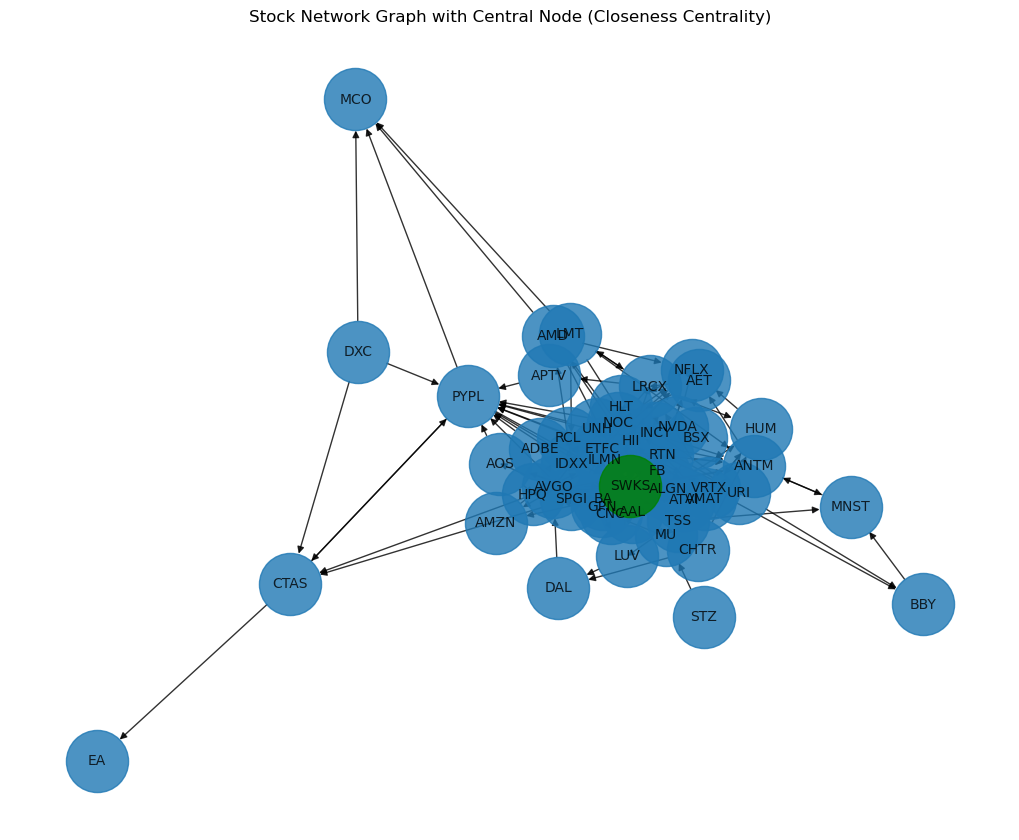

In [31]:
# Calculate the closeness centrality for each node
closeness_centrality = nx.closeness_centrality(G)

# Find the node with the highest closeness centrality (most central node)
central_node = max(closeness_centrality, key=closeness_centrality.get)

# Get the sector of the central node from the 'merged_df' DataFrame
central_node_sector = merged_df[merged_df['name'] == central_node]['sector'].iloc[0]

# Visualize the graph with the central node highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, alpha=0.8)

# Highlight the central node
nx.draw_networkx_nodes(G, pos, nodelist=[central_node], node_color='green', node_size=2000, alpha=0.8)

# Print the name of the central node and its sector
print(f"{central_node} is the central node in terms of closeness centrality.")
print(f"Sector of {central_node}: {central_node_sector}")

# Set plot title
plt.title("Stock Network Graph with Central Node (Closeness Centrality)")

# Show the plot
plt.show()

## PageRank Centrality: Stock Popularity

PageRank centrality is based on the concept of "voting" or "endorsement" by other important nodes in the network. In this context, the PageRank score of SWKS indicates that it is well-connected to other nodes that themselves have high centrality scores.

A higher PageRank centrality suggests that SWKS has strong connections with other top-performing stocks and is likely to be influenced by, or influence, other important stocks in the network. This centrality measure can be interpreted as an indication of how "popular" or "influential" SWKS is within the network of Top 50 S&P Stocks. It is likely that SWKS plays a significant role in transmitting information or market sentiment to other stocks, making it a key player in the dynamics of the stock market.

Investors and analysts may take note of SWKS's high PageRank centrality, as it could be an essential stock to monitor for potential trends or changes in the market. Its influence may impact the behavior and returns of other stocks in the network, making it an important factor in making investment decisions and understanding the overall dynamics of the top-performing stocks.

SWKS is the central node in terms of PageRank centrality.
Sector of SWKS: Information Technology


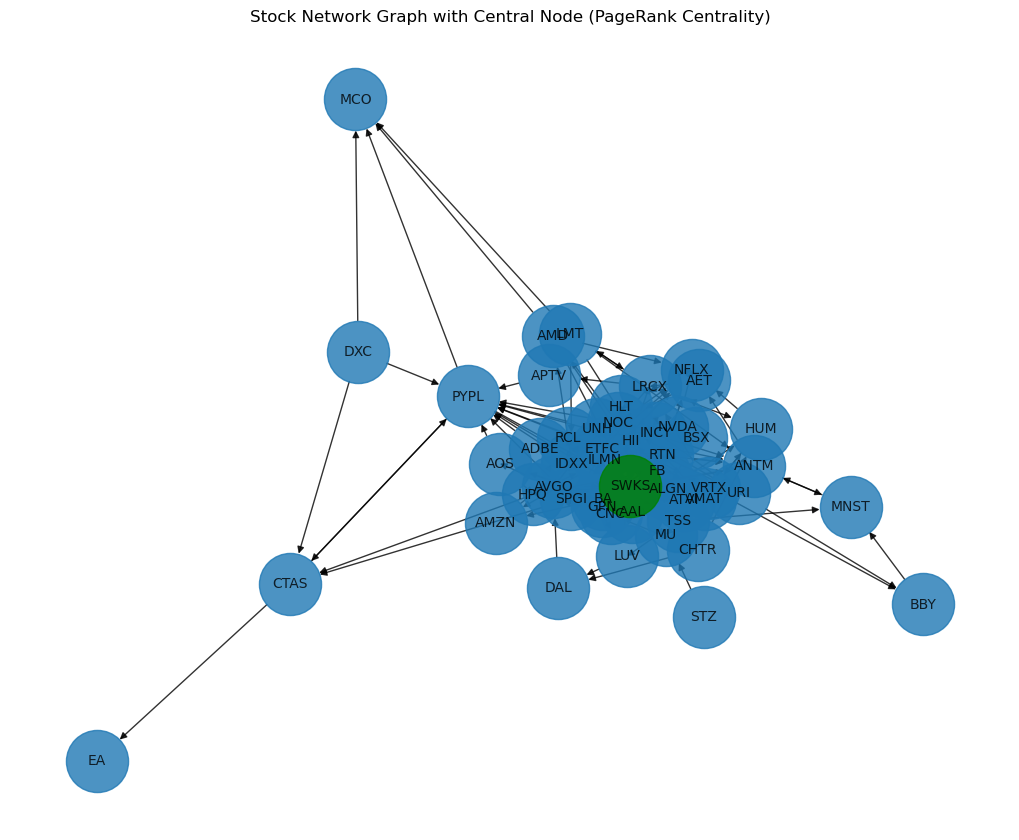

In [32]:
# Calculate the PageRank centrality for each node
pagerank_centrality = nx.pagerank(G)

# Find the node with the highest PageRank centrality (most central node)
central_node = max(pagerank_centrality, key=pagerank_centrality.get)

# Get the sector of the central node from the 'merged_df' DataFrame
central_node_sector = merged_df[merged_df['name'] == central_node]['sector'].iloc[0]

# Visualize the graph with the central node highlighted
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, alpha=0.8)

# Highlight the central node
nx.draw_networkx_nodes(G, pos, nodelist=[central_node], node_color='green', node_size=2000, alpha=0.8)

# Print the name of the central node and its sector
print(f"{central_node} is the central node in terms of PageRank centrality.")
print(f"Sector of {central_node}: {central_node_sector}")

# Set plot title
plt.title("Stock Network Graph with Central Node (PageRank Centrality)")

# Show the plot
plt.show()

# Detecting Stock Communities using Louvain Algorithm

The Louvain community detection algorithm is like a special tool designed to find groups of closely connected nodes in a big network. It was created in 2008 to quickly and efficiently discover these groups, also known as communities. The algorithm uses a clever idea called "modularity," which aims to make each community have more connections within it than we would expect by chance. This way, it can spot meaningful clusters of nodes that stick together tightly. [9]

From the community analysis, we observe:

1. **Stock Clustering:** The communities identified in the network represent groups of stocks that exhibit similar patterns and relationships in terms of stock returns. These clusters suggest that certain groups of companies may share common factors or industry dynamics that impact their performance in the stock market. The presence of distinct communities highlights the diverse nature of the stock market and the different sectors driving its fluctuations.<br><br>

2. **Sector Dominance:** The community centers, represented by the "Community Center" column, are stocks that play a significant role in their respective communities. These central nodes, such as VRTX (Vertex Pharmaceuticals Inc.) in Community 0 (Health Care), DAL (Delta Air Lines Inc.) in Community 1 (Industrials), CTAS (Cintas Corporation) in Community 2 (Industrials), LRCX (Lam Research Corporation) in Community 3 (Information Technology), ILMN (Illumina Inc.) in Community 4 (Health Care), and SWKS (Skyworks Solutions Inc.) in Community 5 (Information Technology), have the highest influence within their communities, indicating their potential importance in their respective industries. <br><br> It is worth noting that multiple communities can have the same sector center, as observed in the cases of DAL (Delta Air Lines Inc.) and CTAS (Cintas Corporation), both centered in the Industrials sector. This indicates that these particular companies hold a significant position in the stock market, being influential not just within their specific sectors but also interconnected with other stocks from different sectors. Their prominence in more than one community suggests their diversified connections and relevance across various industry segments. <br><br> Analyzing the characteristics of these central stocks can provide valuable insights into the dynamics of their sectors. Understanding why certain companies bridge multiple communities can reveal underlying patterns of interdependence and cross-sector relationships. Such insights are crucial for investors, portfolio managers, and analysts seeking to grasp the broader impact of these influential stocks on the stock market and their respective industries. By recognizing the intricacies of sector dominance within the stock market network, market participants can make informed decisions and develop more resilient investment strategies that account for the interplay of stocks across different sectors.<br><br>

3. **Community Sizes:** The size of each community, indicated by the "Community Size" column, reflects the number of nodes (stocks) within that community. Larger communities like Community 3 (centered around LRCX) with 12 stocks, Community 4 (centered around ILMN) with 11 stocks, and Community 5 (centered around SWKS) with 8 stocks suggest that more stocks share similar relationships and dependencies within these clusters. Smaller communities, such as Community 1 (centered around DAL) with 4 stocks, and Community 2 (centered around CTAS) with 6 stocks, may represent niche sectors with unique patterns and fewer interconnected stocks.<br><br>

4. **Investment Strategies:** The identification of these stock communities offers potential benefits for investors and portfolio managers. Stocks within the same community may show similar price movements and correlations, which can be crucial for diversification and risk management. Investors can strategically allocate their investments across communities to balance risk and enhance returns, depending on the specific characteristics of each cluster.<br><br>

5. **Market Interactions:** By understanding how stocks interact within and between communities, traders and analysts can identify potential arbitrage opportunities and market inefficiencies. Stocks with strong connections between different communities could be valuable for understanding cross-sector dynamics and predicting broader market trends.<br><br>

6. **Risk Assessment:** The community structure of the stock market can provide insights into systematic risk factors. Companies within the same community may face similar economic challenges and opportunities, leading to correlated risk exposure. Recognizing these interdependencies can help in assessing and managing overall portfolio risk.

Number of communities in the Stock Network: 6


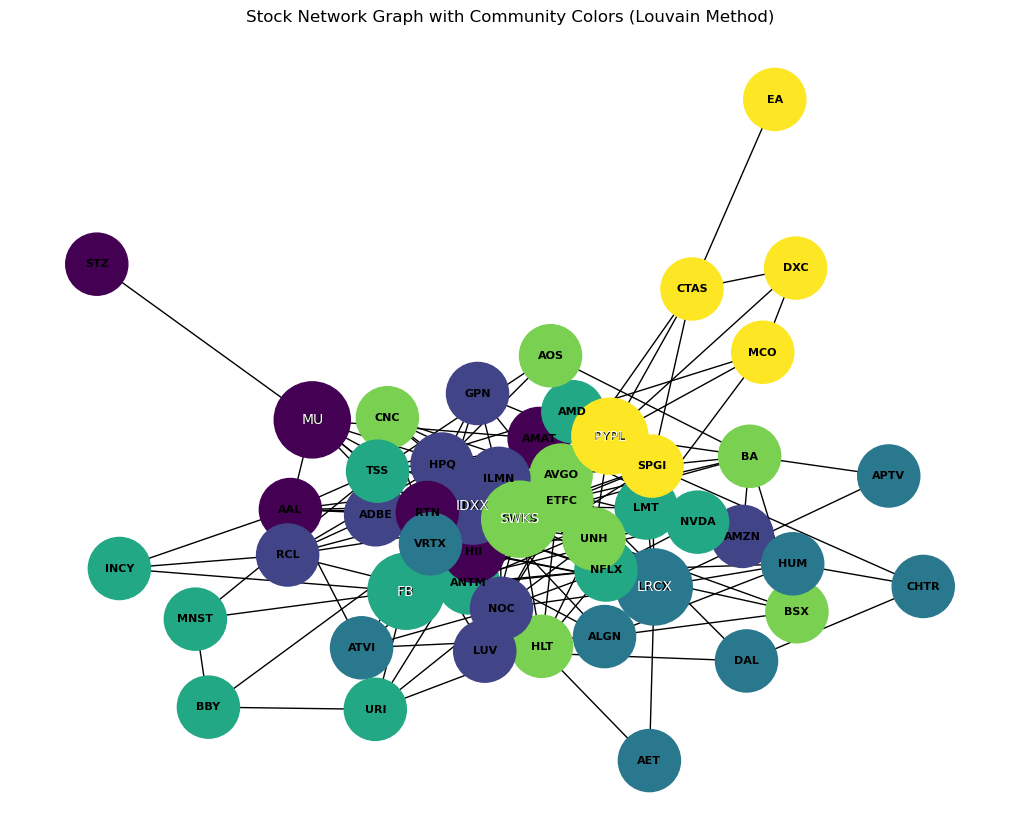

In [33]:
# Convert the directed graph to an undirected graph
undirected_G = G.to_undirected()

# Use the Louvain method for community detection
communities = community.best_partition(undirected_G)

# Get the number of communities
num_communities = len(set(communities.values()))

# Print the number of communities
print(f"Number of communities in the Stock Network: {num_communities}")

# Find the center node for each community (highest degree centrality)
community_centers = {}
for community_id in set(communities.values()):
    community_nodes = [node for node, comm_id in communities.items() if comm_id == community_id]
    subgraph = undirected_G.subgraph(community_nodes)
    degree_centrality = nx.degree_centrality(subgraph)
    center_node = max(degree_centrality, key=degree_centrality.get)
    community_centers[community_id] = center_node

# Visualize the communities with their respective centers labeled
pos = nx.spring_layout(undirected_G, seed=42)
plt.figure(figsize=(10, 8))

# Create a mapping from node IDs to indices
node_to_index = {node: index for index, node in enumerate(undirected_G.nodes())}

# Draw nodes with community colors and individual node sizes
node_colors = [communities[node] for node in undirected_G.nodes()]
node_sizes = [2000 for _ in undirected_G.nodes()]
for center_node in community_centers.values():
    node_sizes[node_to_index[center_node]] = 3000

nx.draw(undirected_G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.get_cmap('viridis'), node_size=node_sizes, font_size=8, font_weight='bold')

# Draw the labels for the community centers
labels = {node: node for node in community_centers.values()}
nx.draw_networkx_labels(undirected_G, pos, labels, font_size=10, font_color='white')

plt.title("Stock Network Graph with Community Colors (Louvain Method)")
plt.show()

In [34]:
# Create the DataFrame to store community and center node information
community_df = pd.DataFrame(columns=['Community', 'Community Center', 'Community Size', 'Sector'])

# Find the center node for each community (highest degree centrality)
community_centers = {}
for community_id in set(communities.values()):
    community_nodes = [node for node, comm_id in communities.items() if comm_id == community_id]
    community_size = len(community_nodes)
    subgraph = undirected_G.subgraph(community_nodes)
    degree_centrality = nx.degree_centrality(subgraph)
    center_node = max(degree_centrality, key=degree_centrality.get)
    community_centers[community_id] = center_node
    
    # Get the sector of the community center from the 'merged_df' DataFrame
    center_node_sector = merged_df[merged_df['name'] == center_node]['sector'].iloc[0]
    
    community_df.loc[len(community_df)] = [community_id, center_node, community_size, center_node_sector]

# Print the DataFrame showing community, community center, community size, and sector information
community_df

Community Community Center  Community Size                  Sector
0          0               MU               6  Information Technology
1          1             IDXX               9             Health Care
2          2             LRCX               9  Information Technology
3          3               FB              11                     NaN
4          4             SWKS               9  Information Technology
5          5             PYPL               6              Financials

# **Insights and Reflection**

The power law distribution and diverse nature of the stock market highlight the significance of certain sectors and influential stocks. Understanding the interconnections among top-performing stocks and their community structure offers valuable insights for investors and analysts seeking to make informed decisions, manage risk, and capitalize on market opportunities. By leveraging network analysis and community detection algorithms, we can unravel the complexities of the financial markets and navigate the dynamic world of investments.

1. **Power Law and Diversity in the Network:**
   - The presence of a power law distribution in the sector distribution of the Top 50 S&P Stocks reveals that a few sectors dominate the market, while others have fewer representatives. This mirrors the typical pattern seen in complex systems like financial markets.
   - The Health Care, Industrials, and IT sectors stand out as the top performers, comprising more than half of the Top 50 S&P Stocks. Their strong performance indicates their significance in driving overall market returns.
   - The Consumer Discretionary sector's higher representation in the Top 50 S&P Stocks suggests robust consumer demand and spending patterns, influencing its stocks' performance.
   - On the other hand, the Energy, Materials, Real Estate, and Utilities sectors' absence from the Top 50 S&P Stocks may indicate lower returns or higher risk in these sectors.<br><br>

2. **Scale-Free Stock Network:**
   - The Stock Network's power law distribution in node degrees reveals a few hub stocks with significant influence and numerous less-connected stocks. These hubs play a crucial role in transmitting information and trends across the network.
   - **SWKS (Skyworks Solutions Inc.)** emerges as the central node based on various centrality measures, indicating its high influence and potential impact on other stocks. Its behavior could serve as an indicator of broader market trends.
   - **LRCX (Lam Research Corporation)** and other top-ranked stocks in different centrality measures are vital players in their respective sectors, driving trends and influencing market sentiment.<br><br>

3. **Louvain Community Detection Algorithm:**
   - The Louvain algorithm uncovers communities of closely connected stocks, reflecting shared patterns and relationships in their returns.
   - Some stocks, like **DAL (Delta Air Lines Inc.)** and **CTAS (Cintas Corporation)**, bridge multiple communities, indicating their diversified connections and relevance across sectors.
   - Understanding the characteristics of these central stocks can reveal patterns of interdependence and cross-sector relationships, essential for investment decisions and portfolio management.
   - The community structure offers opportunities for investors to diversify their investments, manage risk, and identify potential arbitrage opportunities and market inefficiencies.<br><br>

4. **Investment Strategies and Risk Assessment:**
   - Investors can strategically allocate investments across stock communities to balance risk and enhance returns, considering their correlations and price movements.
   - Recognizing interdependencies within communities can help assess and manage overall portfolio risk, particularly when companies face similar economic challenges and opportunities.
   - Analyzing market interactions and cross-sector dynamics can aid in predicting broader market trends and identifying systematic risk factors.

# Conclusion

The study of the stock market using network analysis and community detection has provided valuable insights into the relationships among top-performing stocks and the significance of certain sectors. 

Observing and understanding influential stocks and their impact on the market offers opportunities for making informed decisions, mitigating risks, and capitalizing on market opportunities more effectively.

However, it is important to note that time series data like stock market data are inherently dynamic, and stock market relationships can change over time. It is important to consider conducting the analysis over multiple time windows to capture temporal variations in links and relationships between stocks.

# References

[1] Neufeld, Dorothy. "Visualizing Every Company on the S&P 500 Index." Visual Capitalist, published on June 21, 2023. https://advisor.visualcapitalist.com/complete-breakdown-of-sp-500-companies/

[2] S&P Global. (n.d.). Our History. Who We Are. Retrieved from https://www.spglobal.com/en/who-we-are/our-history

[3] S&P Dow Jones Indices. (n.d.). S&P 500® - S&P Dow Jones Indices. Retrieved from https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview

[4] Barabasi, A. (2016). Network Science. Retrieved from http://networksciencebook.com/

[5] Bai, S., Cui, W. & Zhang, L. The Granger causality analysis of stocks based on clustering. Cluster Comput 22 (Suppl 6), 14311–14316 (2019). https://doi.org/10.1007/s10586-018-2290-0

[6] Nugent, C. (2021, October 20). CNuge/kaggle-code. GitHub. https://github.com/CNuge/kaggle-code

[7] Morgan Stanley Capital International (MSCI). (n.d.). The Global Industry Classification Standard (GICS). Retrieved 2023, August 1 from https://www.msci.com/our-solutions/indexes/gics

[8] Disney, A. (2020, January 2). Social network analysis 101: centrality measures explained. Cambridge Intelligence. Retrieved from https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/

[9] Jayawickrama, T. D. (2021, January 29). Community Detection Algorithms. Towards Data Science. https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae

[10] Kesarwani, A. (April 24, 2018). Word clouds of various shapes. Kaggle. https://www.kaggle.com/datasets/aashita/masks